## Overview:

#### The Boston Marathon is an annual marathon hosted by several cities in greater Boston in eastern Massachusetts, United States. Our data is ** Finishers Boston Marathon 2017**. It contains 26410 rows and 25 variables. 


## In this analysis, we are doing:
* Data description
* Exploratory data analysis
* Data modeling

## Part1: Data Description:


### * Content:
The data is downloaded from Kaggle. According to their offical data information from this website: *http://registration.baa.org/2017/cf/Public/iframe_Statistics.htmThe* we know that 97% of participants finished the marathon. 
variable in this data set are: *Name, Age, Gender, Country, City and State (where available), Times at 9 different stages of the race, expected time, Finish time and Pace, Overall place, Gender place and Division place*.

### * Description:
The data has 25 different variables: *Name, Age, Gender, Country, City and State (where available), Times at 9 different stages of the race, expected time, Finish time and Pace, Overall place, Gender place and Division place*.


## Part2：Exploratory Data Analysis:

In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import datetime as DT
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('marathon_results_2017.csv')
print(data.shape)
print(data.info())
print(data.describe())
# as we can see, there is 26410 rows and 25 variables,
#not many NaN values.

(26410, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26410 entries, 0 to 26409
Data columns (total 25 columns):
Unnamed: 0       26410 non-null int64
Bib              26410 non-null object
Name             26410 non-null object
Age              26410 non-null int64
M/F              26410 non-null object
City             26410 non-null object
State            22815 non-null object
Country          26410 non-null object
Citizen          1254 non-null object
Unnamed: 9       91 non-null object
5K               26410 non-null object
10K              26410 non-null object
15K              26410 non-null object
20K              26410 non-null object
Half             26410 non-null object
25K              26410 non-null object
30K              26410 non-null object
35K              26410 non-null object
40K              26410 non-null object
Pace             26410 non-null object
Proj Time        26410 non-null object
Official Time    26410 non-null object
Overall          26410 non-

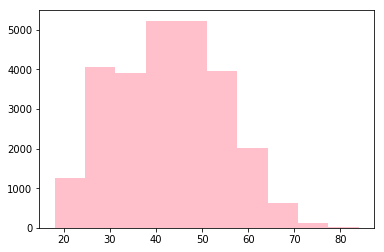

Text(0.5,1,'Participation in 2017')

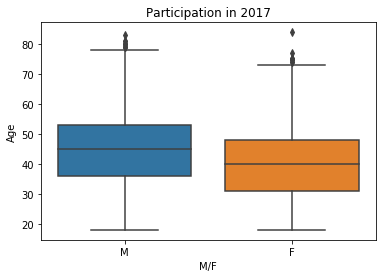

In [3]:
plt.hist(data.Age,color='pink')  #the age varies from 18 to 84 years old.
plt.show()
g = sns.boxplot(data['M/F'], data['Age'])
g.set_title("Participation in 2017")

In [14]:
#convert official finish time format to minutes so we can calculate the speed mean 
def convert_to_minutes(time):
    minutes = time.str.split(':').map(lambda x: int(x[-1]) / 60 + int(x[-2]) + int(x[-3]) * 60)
    return minutes
data['Time_Minutes'] = convert_to_minutes(data['Official Time'])
data.loc[:,['Official Time','Time_Minutes']].head()

,Official Time,Time_Minutes
0,2:09:37,129.616667
1,2:09:58,129.966667
2,2:10:28,130.466667
3,2:12:08,132.133333
4,2:12:35,132.583333


In [15]:
#Calcualte mean of finish time for each age group
time = data.loc[:,['Time_Minutes']]
decade = pd.cut(data.Age,bins=np.arange(10,99,10),right=False)
time["DECADE"] = decade
summary = time.groupby('DECADE')['Time_Minutes'].mean()
summary.index = np.arange(10,90,10) 
print(summary)   
#fastest group is 30-39 years old

10    255.197090
20    232.576644
30    228.135193
40    235.063972
50    246.556823
60    265.788384
70    292.434007
80    296.754762
Name: Time_Minutes, dtype: float64


## Top 15 Fastest Countries

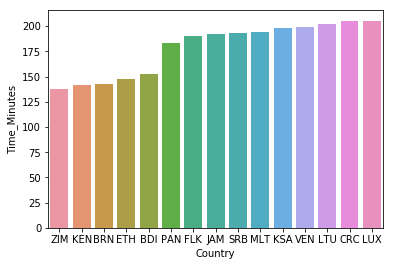

In [98]:
top_15_countries = data.groupby("Country")['Time_Minutes'].mean().nsmallest(15)

top15_countries = data.loc[data['Country'].isin(np.array(top_15_countries.index))]
top15_countries = top15_countries.groupby('Country')['Time_Minutes'].mean()
top15_countries = pd.DataFrame(top15_countries)
top15_countries = top15_con.sort_values(['Time_Minutes'])
sns.barplot(x = top15_con.index, y = top15_con.Time_Minutes)

## Worst 15 Countries

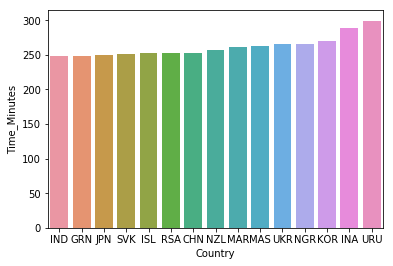

In [97]:
worst_15_countries = data.groupby("Country")['Time_Minutes'].mean().nlargest(15)

worst15_countries = data.loc[data['Country'].isin(np.array(worst_15_countries.index))]
worst15_countries = worst15_countries.groupby('Country')['Time_Minutes'].mean()
worst15_countries = pd.DataFrame(worst15_countries)
worst15_countries = worst15_countries.sort_values(['Time_Minutes'])
sns.barplot(x = worst15_countries.index, y = worst15_countries.Time_Minutes)

## Part3: Data modeling: